In [381]:
# %load ../scripts/f_common_script.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import re
import scienceplots
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

# Section:Global variables
my_seed = 42
np.random.seed(my_seed)


# Section:Functions for plotting
def add_trendline(x: np.ndarray, y: np.ndarray, ax: plt.Axes) -> None:
    """
    Adds a quadratic trendline to a given plot.

    This function sorts the input data, fits a second-order polynomial
    to the sorted data, and plots the resulting trendline on the provided
    Axes object.

    Parameters:
    x (np.ndarray or array-like): The x-coordinates of the data points.
    y (np.ndarray or array-like): The y-coordinates of the data points.
    ax (matplotlib.axes.Axes): The Axes object on which to plot the trendline.

    Returns:
    None
    """
    # Sort x and y values to ensure a continuous line
    # convert x and y to numpy array
    x = np.array(x)
    y = np.array(y)
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]

    # Fit polynomial and create trendline
    z = np.polyfit(x_sorted, y_sorted, 2)
    p = np.poly1d(z)
    ax.plot(x_sorted, p(x_sorted), "--", color='red', linewidth=2)


def plot_actual_vs_predicted(y_test: np.ndarray, y_pred: np.ndarray, fig_name: str = '../figs/actual_vs_predicted.pdf', xlabel: str = 'Actual', ylabel: str = 'Estimated', trendline: bool = True) -> None:
    """
    Plots the actual vs. predicted values and optionally a trendline.
    This function creates a scatter plot of the actual vs. predicted values,
    draws a reference line of y=x, and optionally adds a quadratic trendline.
    The plot is saved as a PDF file.

    Parameters:
    y_test (array-like): The actual values.
    y_pred (array-like): The predicted values.
    fig_name (str): The file path where the plot will be saved. Default is '../figs/actual_vs_predicted.pdf'.
    xlabel (str): The label for the x-axis. Default is 'Actual'.
    ylabel (str): The label for the y-axis. Default is 'Estimated'.
    trendline (bool): Whether to add a trendline to the plot. Default is True.

    Returns:
    None
    """
    # plot the actual vs predicted, with a line of y=x
    plt.style.use(['science'])
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [
        y_test.min(), y_test.max()], 'k-', lw=2)
    if trendline:
        add_trendline(y_test, y_pred, ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.savefig(fig_name, format='pdf')
    plt.show()


def df_common_xylabel_plot(df: pd.DataFrame, y: list[str], doy_start: int = 0, doy_end: int = 366, year: list[int] = [2017, 2018, 2019], xlabel: str = 'Datetime', ylabel: str = "example ylabel", layout: tuple = (7, 4), subplots: bool = True, figsize: tuple = (20, 20)) -> None:
    """
    Plots specified columns of a DataFrame over a given range of time.

    This function filters the DataFrame based on the day of the year and the specified years,
    and then plots the specified columns against the 'datetime' column. It supports creating
    subplots and adds common x and y labels to the figure.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data to plot.
    y (str or list of str): The column(s) to plot on the y-axis.
    doy_start (int): The starting day of the year for filtering. Default is 0.
    doy_end (int): The ending day of the year for filtering. Default is 366.
    year (list of int): The years to include in the plot. Default is [2017, 2018, 2019].
    xlabel (str): The label for the x-axis. Default is 'Datetime'.
    ylabel (str): The label for the y-axis. Default is 'example ylabel'.
    layout (tuple): The layout of the subplots (rows, columns). Default is (7, 4).
    subplots (bool): Whether to create subplots for each column. Default is True.
    figsize (tuple): The size of the figure. Default is (20, 20).

    Returns:
    None
    """
    # make a list of columns to plot, excluding the columns of datetime and Timestamp
    axes = df[(df['doy'] >= doy_start) & (df['doy'] <= doy_end) & (df['year'].isin(year))].plot(
        x='datetime', y=y, subplots=subplots, figsize=figsize, layout=layout, sharex=True, xlabel='')
    if subplots == True:
        fig = axes[0, 0].get_figure()
    else:
        fig = axes.get_figure()  # to avoid the problem of "'Axes' object is not subscriptable"
    # add a common y label
    fig.text(0.08, 0.5, ylabel, va='center', rotation='vertical', size=20)
    # add a common x label
    fig.text(0.5, 0.0, xlabel, ha='center', size=20)


In [382]:
def calc_percentage_error(real_capacities: np.ndarray, estimated_capacities: np.ndarray) -> float:
    """
    Calculates the percentage error between real and estimated capacities.

    This function computes the percentage error. If any of the input arrays contain NaN values,
    the function returns NaN.

    Parameters:
    real_capacities (np.ndarray or array-like): The actual capacities.
    estimated_capacities (np.ndarray or array-like): The estimated capacities.

    Returns:
    float: The percentage error, or NaN if any input contains NaN values.
    """
    if np.isnan(real_capacities).any() or np.isnan(estimated_capacities).any():
        return np.nan
    return (real_capacities.sum() - estimated_capacities.sum()) / real_capacities.sum() * 100
def calc_mean_percentage_error(real_capacities: np.ndarray, estimated_capacities: np.ndarray) -> float:
    """
    Calculates the mean percentage error between real and estimated capacities.

    This function computes the mean percentage error averaging over the individual
    percentage errors for each household in the input arrays.
    If any of the input arrays contain NaN values, the function returns NaN.

    Parameters:
    real_capacities (array-like): The actual capacities.
    estimated_capacities (array-like): The estimated capacities.

    Returns:
    float: The mean percentage error, or NaN if any input contains NaN values.
    """
    if np.isnan(real_capacities).any() or np.isnan(estimated_capacities).any():
        return np.nan
    # n is the length of real_capacities
    n=real_capacities.size
    # individual_errors is the percentage error of each household
    individual_errors = (real_capacities - estimated_capacities)/real_capacities # Avoid division by zero
    return individual_errors.sum()/n*100
def calc_error_factor(real_capacities_sum: float, estimated_capacities_sum: float) -> float:
    """
    Calculates the error factor between real and estimated capacities.

    This function computes the error factor by dividing the sum of real capacities
    by the sum of estimated capacities.

    Parameters:
    real_capacities_sum (float): The sum of real capacities.
    estimated_capacities_sum (float): The sum of estimated capacities.

    Returns:
    float: The error factor, or NaN if any input contains NaN values.
    """
    return real_capacities_sum/estimated_capacities_sum

def calc_r2_score(real_capacities: np.ndarray, estimated_capacities: np.ndarray) -> float:
    """
    Calculates the R2 score between real and estimated capacities.

    This function computes the R2 score by comparing the sum of real capacities
    to the sum of estimated capacities.

    Parameters:
    real_capacities (np.ndarray or array-like): The actual capacities.
    estimated_capacities (np.ndarray or array-like): The estimated capacities.

    Returns:
    float: The R2 score, or NaN if any input contains NaN values.
    """
    # if there is any NaN in real_capacities or estimated_capacities, return NaN
    # otherwise, return the R2 score
    if np.isnan(real_capacities).any() or np.isnan(estimated_capacities).any():
        return np.nan
    return r2_score(real_capacities,estimated_capacities)

# Load data

In [383]:
f_name='../data/nl/ams_data_merged_preprocessed.csv'
f_name_pv_capacity = '../data/nl/ams_pv_capacity_from_pv_profiles.csv'
df = pd.read_csv(f_name)
df_pv_capacity = pd.read_csv(f_name_pv_capacity)

In [384]:
# split the df_pv_capacity into part 1 and part 2, the first 10 household are part 1, the rest are part 2
df_pv_capacity_part1=df_pv_capacity.drop(df_pv_capacity.index[10:])
df_pv_capacity_part2=df_pv_capacity.drop(df_pv_capacity.index[:10])

In [385]:
df_pv_capacity_part1.shape

(10, 2)

In [386]:
f_name1='../data/nl/ams_data_merged_preprocessed_part1.csv'
df_part1=pd.read_csv(f_name1)
f_name2='../data/nl/ams_data_merged_preprocessed_part2.csv'
df_part2=pd.read_csv(f_name2)

In [387]:
df_pv_capacity

,Unnamed: 0,0
0,1011W,2963.038537
1,1954W,2819.092155
2,1955A,2825.082006
3,1964J,2770.849033
4,2053G,3409.944232
5,2442E,1446.058540
6,3070L,2465.613342
7,3517V,879.807524
8,3660D,2857.514911
9,3726A,3065.970353


In [388]:
# rename the first column of df_pv_capacity to 'household', second to 'capacity'
df_pv_capacity.rename(columns={df_pv_capacity.columns[0]: 'household', df_pv_capacity.columns[1]: 'capacity'}, inplace=True)
df_pv_capacity


,household,capacity
0,1011W,2963.038537
1,1954W,2819.092155
2,1955A,2825.082006
3,1964J,2770.849033
4,2053G,3409.944232
5,2442E,1446.058540
6,3070L,2465.613342
7,3517V,879.807524
8,3660D,2857.514911
9,3726A,3065.970353


In [389]:
df_pv_capacity_part1.rename(columns={df_pv_capacity_part1.columns[0]: 'household', df_pv_capacity_part1.columns[1]: 'capacity'}, inplace=True)
df_pv_capacity_part2.rename(columns={df_pv_capacity_part2.columns[0]: 'household', df_pv_capacity_part2.columns[1]: 'capacity'}, inplace=True)
df_pv_capacity_part1
df_pv_capacity_part2

,household,capacity
10,3932W,981.130065
11,4451M,5192.548449
12,5427W,1374.035231
13,5815T,2848.621677
14,7426U,934.936854
15,7679U,2871.897837
16,7710F,1574.498716
17,8319Q,2803.467388
18,9248C,965.216083
19,9370J,2554.771613


In [390]:
# drop the below columns for the following reasons:
# 9506H, because there is no solar panels.
# 4226R, because there is weird data in 2019 March.
# 7743P, for the high missing rate of 0.948231.
# 7099P, because none of its data is in summer.
# 3307S and 2108P, because they seem to have some demand response strategies.
households_to_remove = ['9506H', '4226R', '7743P', '7099P', '3307S', '2108P']
df_pv_capacity = df_pv_capacity[~df_pv_capacity['household'].isin(households_to_remove)]

In [391]:
df_pv_capacity

,household,capacity
0,1011W,2963.038537
1,1954W,2819.092155
2,1955A,2825.082006
3,1964J,2770.849033
4,2053G,3409.944232
5,2442E,1446.058540
6,3070L,2465.613342
7,3517V,879.807524
8,3660D,2857.514911
9,3726A,3065.970353


In [392]:
# columns that ends with '_pv'
pv_cols = [col for col in df.columns if col.endswith('_pv')]
# columns that ends with '_con'
con_cols = [col for col in df.columns if col.endswith('_con')]
# columns that ends with '_net'
net_cols = [col for col in df.columns if col.endswith('_net')]

# Check the distribution of irradiance

This gives us a rough idea of the thresholds of irradiance to use.

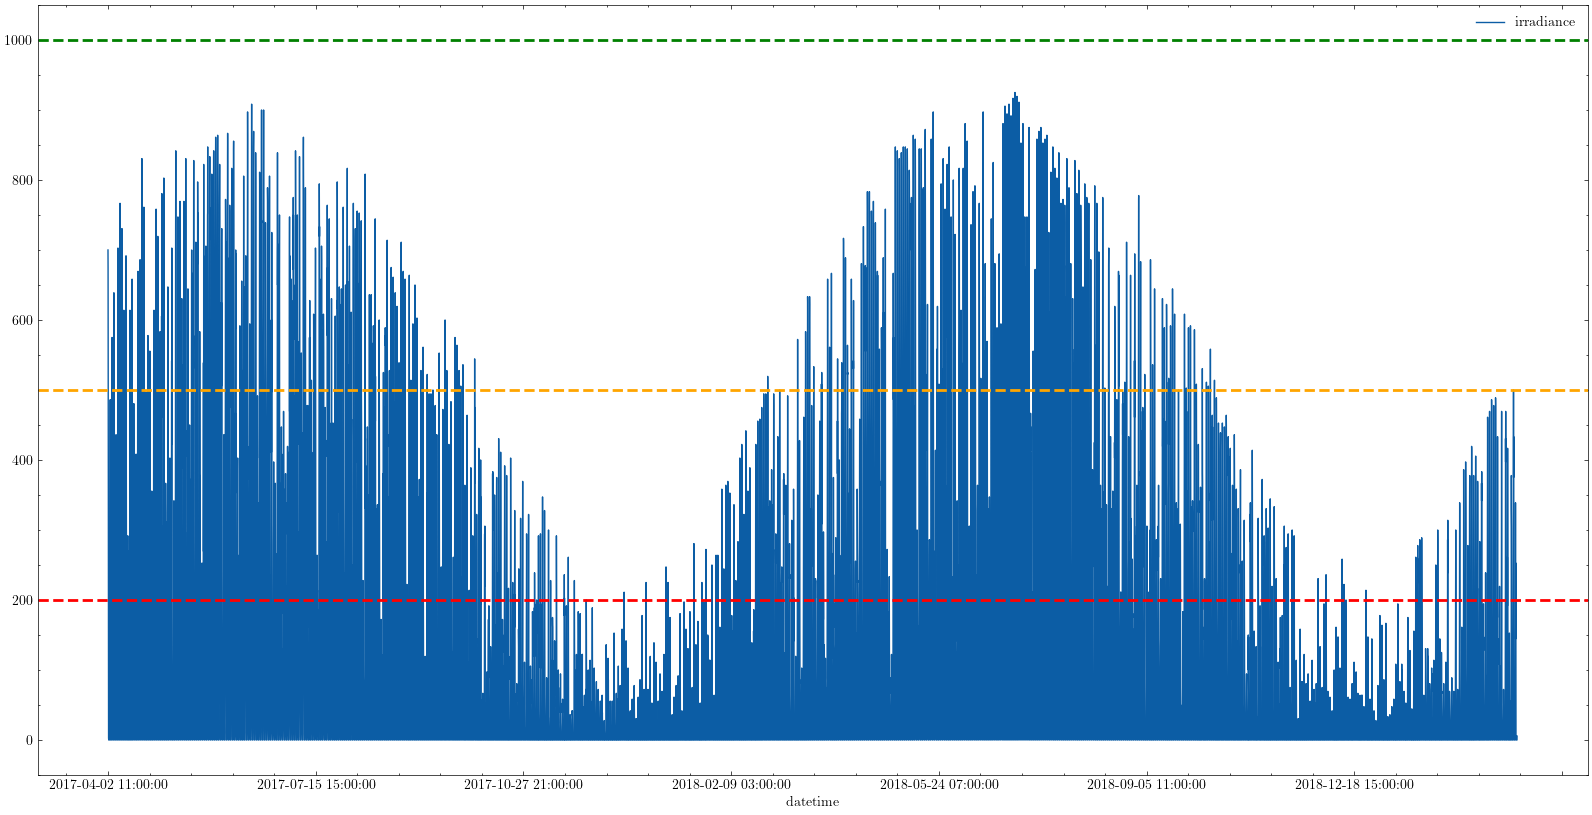

In [393]:
df_part1.plot(x='datetime',y='irradiance',figsize=(20,10))
# draw a line where y=200
plt.axhline(y=200, color='red', linewidth=2, linestyle='--')
# draw a line where y=500
plt.axhline(y=500, color='orange', linewidth=2, linestyle='--')
# draw a line where y=1000
plt.axhline(y=1000, color='green', linewidth=2, linestyle='--')
plt.show()

# Capacity estimation based on base load

## Define the method

In [394]:
class capacity_estimation_base_load:
    """
    A class for estimating the capacity of PV systems.
    Step 1: Sample the net load at night time as base load, when irradiance is low and PV gen is (nearly) zero.
    Step 2: Sample the load when the irradiance is below a certain threshold as noon load.
    Step 3: Calculate the capacity, which is (base load - noon load) * correction factor,
    where the correction factor is (max_irradiance/sample_irradiance). This correction factor originates the (nearly) linear relationship between irradiance and PV gen.
    """
    def __init__(self, df: pd.DataFrame, cols: list, irradiance_threshold_noon: float=500, irradiance_threshold_night: float =0.01, max_irradiance: float =1000,base_load_correction_factor: float =None):
        self.df = df
        self.cols = cols
        self.irradiance_threshold_noon = irradiance_threshold_noon
        self.irradiance_threshold_night= irradiance_threshold_night
        self.max_irradiance = max_irradiance
        self.base_load_correction_factor = base_load_correction_factor
        # why higher threshold_noon?
        # because the when PV gen is dominating, the error is smaller.
        self.base_load = None
        self.correction_factors = None
    def estimate_capacity(self) -> pd.Series:
        self.base_load_estimation()
        self.noon_load_estimation()
        # first use base_load - peak_load, then use the correction factor
        pv_gen_not_corrected = self.base_load - self.high_irradiance_df[self.cols] 
        pv_gen_corrected = pv_gen_not_corrected.multiply(self.correction_factors, axis=0)
        pv_gen_capacity= pv_gen_corrected.mean()
        return pv_gen_capacity
    def base_load_estimation(self):
        # use the net load at night time as the base load
        # when irradiance is below threshold, the net load is the base load
        self.base_load_at_night = self.df[self.df['irradiance'] < self.irradiance_threshold_night][self.cols].mean()
        # calculate the correction factor based on total_con(at daylight)/total_con(at night)
        if self.base_load_correction_factor is None:
            self.base_load_correction_factor = self.df[self.df['irradiance'] > self.irradiance_threshold_noon]['total_con'].mean() / self.df[self.df['irradiance'] <= self.irradiance_threshold_night]['total_con'].mean()
        self.base_load= self.base_load_at_night * self.base_load_correction_factor
        return None
    def noon_load_estimation(self):
        # add a correction factor here, which is max_irradiance/irradiance
        self.high_irradiance_df = self.df[self.df['irradiance'] > self.irradiance_threshold_noon].copy()
        self.correction_factors = self.max_irradiance / self.high_irradiance_df['irradiance']
        return  None

## Estimate the capacity for all households

Set the base_load_correction_factor to 1, since there is no historical data to calculate the correction factor.

In [395]:
# remove total_net and households to remove from net_cols
households_to_remove_with_suffix = [col + '_net' for col in households_to_remove]
net_cols_without_total_net = [col for col in net_cols if col != 'total_net' and col not in households_to_remove_with_suffix]
# create an instance of capacity_estimation_base_load
cap_est_based_load = capacity_estimation_base_load(df,net_cols_without_total_net,base_load_correction_factor=1)
# estimate the capacity
capacity_based_load = cap_est_based_load.estimate_capacity()

In [396]:
capacity_based_load

1011W_net    2823.161755
1954W_net    2689.799410
1955A_net    2736.579766
1964J_net    2966.476239
2053G_net    3447.785026
2442E_net    1619.973333
3070L_net    2398.441618
3517V_net     732.923527
3660D_net    2786.203874
3726A_net    3218.803670
3932W_net    1006.592511
4451M_net    5621.090991
5427W_net    1424.390341
5815T_net    2885.878527
7426U_net     764.153599
7679U_net    2404.245831
7710F_net     909.281909
8319Q_net    2827.438312
9248C_net     939.249697
9370J_net    2576.076447
9991J_net    6753.452292
dtype: float64

In [397]:
# the length of capacity_based_load should be the same as df_pv_capacity
len(capacity_based_load)

21

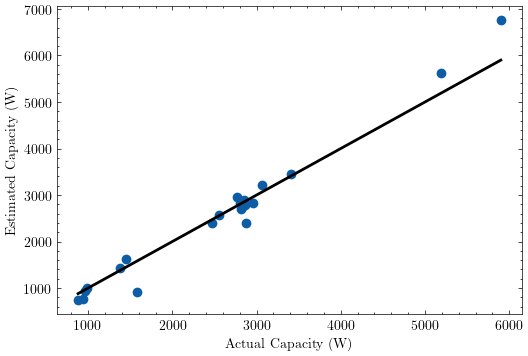

0.9475271825407134

In [398]:
# plot the estimated capacity vs the actual capacity
# the second column of df_pv_capacity is the actual capacity
plot_actual_vs_predicted(df_pv_capacity.iloc[:, 1], capacity_based_load,xlabel='Actual Capacity (W)',ylabel='Estimated Capacity (W)',trendline=False)
# calculate the R2 score
calc_r2_score(df_pv_capacity.iloc[:, 1], capacity_based_load)

From here, we can see that the capacity of other households are well estimated.

In [399]:
# sum up the capacity of all households both real and estimated
real_capacity = df_pv_capacity['capacity'].sum()
estimated_capacity = capacity_based_load.sum()
print(f'The real capacity is {real_capacity} W, and the estimated capacity is {estimated_capacity} W')
# print the error rate
capacity_error_rate = (real_capacity - estimated_capacity) / real_capacity * 100
print(f'The error rate is {capacity_error_rate}%')
error_factor= real_capacity/estimated_capacity
print(f'The error factor is {error_factor}')

The real capacity is 53504.32336904934 W, and the estimated capacity is 53531.99867354572 W
The error rate is -0.051725361155368625%
The error factor is 0.9994830138014247


In [400]:
# save the error rate to a npy file
np.save("../data/nl/capacity_error_rate.npy", capacity_error_rate)
# save the error factor to a npy file
np.save("../data/nl/capacity_error_factor.npy", error_factor)

## Sensitivity analysis

In [401]:
def sensitivity_analysis_irradiance_threshold(df_tmp:pd.DataFrame,real_capacity_tmp:np.ndarray,fig_name:str,base_load_correction_factor:float=None,metric:str='PE'):
    """
    Performs sensitivity analysis on irradiance thresholds and creates a heatmap visualization.

    This function analyzes how different combinations of day and night irradiance thresholds
    affect the capacity estimation accuracy. The values of the heatmap are given by the specified metric.

    Parameters:
    -----------
    df_tmp : pandas.DataFrame
        DataFrame containing the power and irradiance measurements.
    real_capacity_tmp : numpy.ndarray or array-like
        Array of actual PV system capacities.
    fig_name : str
        File path where the resulting heatmap will be saved.
    base_load_correction_factor : float, optional
        Correction factor for base load estimation. Default is None.
    metric : str, optional
        Performance metric to use. Options are:
        - 'PE': Percentage Error
        - 'MPE': Mean Percentage Error
        - 'R2': R-squared score
        Default is 'PE'.

    Returns:
    None
    """
    list_irradiance_thresholds_noon = [10, 20, 30, 40] + list(range(50, 550, 50))
    list_irradiance_thresholds_night = [0.01, 0.1, 1, 10]
    net_cols_without_total_net = [col for col in df_tmp.columns if col.endswith('_net') and col != 'total_net']
    # store the error rates in a matrix
    error_rates = np.zeros((len(list_irradiance_thresholds_noon), len(list_irradiance_thresholds_night)))
    for i, irradiance_threshold_noon in enumerate(list_irradiance_thresholds_noon):
        for j, irradiance_threshold_night in enumerate(list_irradiance_thresholds_night):
            cap_est_based_load = capacity_estimation_base_load(df_tmp,net_cols_without_total_net,irradiance_threshold_noon,irradiance_threshold_night,base_load_correction_factor=base_load_correction_factor)
            capacity_based_load = cap_est_based_load.estimate_capacity()
            if metric == 'PE':
                error_rates[i, j] = calc_percentage_error(real_capacity_tmp,capacity_based_load)
            elif metric == 'MPE':
                error_rates[i, j] = calc_mean_percentage_error(real_capacity_tmp,capacity_based_load)
            elif metric == 'R2':
                error_rates[i, j] = calc_r2_score(real_capacity_tmp,capacity_based_load)
    if metric == 'R2':
        ticks=np.linspace(-1, 1, 11)
        v_min_n_max=[-1, 1]
        cmap='rocket'
        label='$\mathrm{R}^2$'
    if metric == 'PE':
        ticks=np.linspace(-100, 100, 11)
        v_min_n_max=[-100, 100]
        cmap='RdBu_r'
        label='Percentage Error ($\%$)'
    if metric == 'MPE':
        ticks=np.linspace(-100, 100, 11)
        v_min_n_max=[-100, 100]
        cmap='RdBu_r'
        label='Mean Percentage Error ($\%$)'
    # Plot heatmap
    plt.style.use(['science'])
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        error_rates,
        cmap=cmap,
        center=0,
        linewidths=0.1,
        vmin=v_min_n_max[0],
        vmax=v_min_n_max[1],
        xticklabels=list_irradiance_thresholds_night,
        yticklabels=list_irradiance_thresholds_noon,
        annot=True,
        cbar_kws={
            'label': label,
            'ticks': ticks  
        }
    )
    # Configure axis labels
    plt.xlabel('$I_{night}$ (W/m$^2$)')
    plt.ylabel('$I_{day}$ (W/m$^2$)')
    # Rotate y-axis labels to horizontal
    plt.yticks(rotation=0)
    # Save and display
    plt.tight_layout()
    plt.savefig(fig_name, format='pdf')
    plt.show()
    return None

# base_load_correction_factor for two parts

In [402]:
# columns that ends with '_net'
net_cols = [col for col in df_part1.columns if col.endswith('_net')]
# remove total_net and households to remove from net_cols
net_cols_part1 = [col for col in net_cols if col != 'total_net' and col not in households_to_remove_with_suffix]
net_cols_without_total_net_part1 = [col for col in net_cols_part1 if col != 'total_net']
cap_est_based_load_part1_tmp = capacity_estimation_base_load(df_part1,net_cols_without_total_net_part1)
cap_est_based_load_part1_tmp.estimate_capacity()
base_load_correction_factor_from_part1=cap_est_based_load_part1_tmp.base_load_correction_factor

In [403]:
# columns that ends with '_net'
net_cols = [col for col in df_part2.columns if col.endswith('_net')] 
# remove total_net and households to remove from net_cols
net_cols_part2 = [col for col in net_cols if col != 'total_net' and col not in households_to_remove_with_suffix]
net_cols_without_total_net_part2 = [col for col in net_cols_part2 if col != 'total_net']
cap_est_based_load_part2_tmp = capacity_estimation_base_load(df_part2,net_cols_without_total_net_part2)
cap_est_based_load_part2_tmp.estimate_capacity()
base_load_correction_factor_from_part2=cap_est_based_load_part2_tmp.base_load_correction_factor

In [404]:
print(f'base_load_correction_factor_from_part2: {base_load_correction_factor_from_part2}')

base_load_correction_factor_from_part2: 1.0233585991896819


# Estimation for part 1

In [405]:
# columns that ends with '_net'
net_cols = [col for col in df_part1.columns if col.endswith('_net')]
# create an instance of capacity_estimation_base_load
# remove total_net and households to remove from net_cols
net_cols_part1 = [col for col in net_cols if col != 'total_net' and col not in households_to_remove_with_suffix]
net_cols_without_total_net = [col for col in net_cols_part1 if col != 'total_net']

cap_est_based_load_part1 = capacity_estimation_base_load(df_part1,net_cols_without_total_net,base_load_correction_factor=base_load_correction_factor_from_part2)
# cap_est_based_load_part1 = capacity_estimation_base_load(df_part1,net_cols_without_total_net,base_load_correction_factor=1)
capacity_based_load_part1 = cap_est_based_load_part1.estimate_capacity()
capacity_based_load_part1

1011W_net    2832.826926
1954W_net    2702.341762
1955A_net    2747.832491
1964J_net    2986.575649
2053G_net    3461.853901
2442E_net    1636.837883
3070L_net    2407.952255
3517V_net     743.028715
3660D_net    2796.097767
3726A_net    3231.682075
dtype: float64

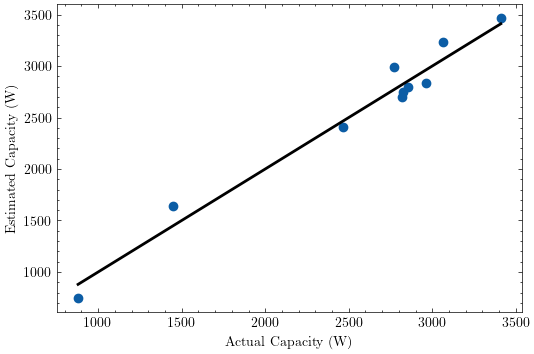

0.968002003553638

In [406]:
# plot the estimated capacity vs the actual capacity
# the second column of df_pv_capacity is the actual capacity
plot_actual_vs_predicted(df_pv_capacity_part1.iloc[:, 1], capacity_based_load_part1,fig_name='../figs/actual_vs_predicted_capacity_part1.pdf',xlabel='Actual Capacity (W)',ylabel='Estimated Capacity (W)',trendline=False)
# calculate the R2 score
calc_r2_score(df_pv_capacity_part1.iloc[:, 1], capacity_based_load_part1)

In [407]:
# sum up the capacity of all households both real and estimated
real_capacity_part1 = df_pv_capacity_part1['capacity'].to_numpy()
estimated_capacity_part1 = capacity_based_load_part1.to_numpy()
real_capacity_part1_sum = df_pv_capacity_part1['capacity'].sum()
estimated_capacity_part1_sum = capacity_based_load_part1.sum()
print(f'The real capacity is {real_capacity_part1_sum} W, and the estimated capacity is {estimated_capacity_part1_sum} W')
PE_part1=calc_percentage_error(real_capacity_part1,estimated_capacity_part1)
print(f'The percentage error is {PE_part1}%')
MPE_part1=calc_mean_percentage_error(real_capacity_part1,estimated_capacity_part1)
print(f'The mean percentage error is {MPE_part1}%')
R2_part1=calc_r2_score(real_capacity_part1,estimated_capacity_part1)
print(f'The R2 score is {R2_part1}')
error_factor_part1= calc_error_factor(real_capacity_part1_sum,estimated_capacity_part1_sum)
print(f'The error factor is {error_factor_part1}')

The real capacity is 25502.97063344348 W, and the estimated capacity is 25547.02942390774 W
The percentage error is -0.17275944476241928%
The mean percentage error is 0.33989328530910273%
The R2 score is 0.968002003553638
The error factor is 0.9982753849876953


In [408]:
# save the error rate and error factor to npy files
np.save("../data/nl/capacity_error_rate_part1.npy", PE_part1)
np.save("../data/nl/capacity_error_factor_part1.npy", error_factor_part1)

## SA for part 1

In [409]:
df_part1_cleaned=df_part1.drop(columns=['1955A_pv','1955A_net'])

In [410]:
# 3 levels of availability, 1 month (2018-06), 3 months(2018-06-2018-08), and 6 months(2018-06-2018-11)
df_part1_1month_summer = df_part1_cleaned[(df_part1_cleaned['datetime'] >= '2018-06-01') & (df_part1_cleaned['datetime'] <= '2018-06-30')]
df_part1_1month_winter = df_part1_cleaned[(df_part1_cleaned['datetime'] >= '2018-12-01') & (df_part1_cleaned['datetime'] <= '2018-12-31')]
df_part1_3months = df_part1_cleaned[(df_part1_cleaned['datetime'] >= '2018-06-01') & (df_part1_cleaned['datetime'] <= '2018-08-31')]
df_part1_6months = df_part1_cleaned[(df_part1_cleaned['datetime'] >= '2018-06-01') & (df_part1_cleaned['datetime'] <= '2018-11-30')]

In [411]:
df_pv_capacity_part1_cleaned = df_pv_capacity_part1[df_pv_capacity_part1['household'] != '1955A']

In [412]:
real_capacity_part1_cleaned = df_pv_capacity_part1_cleaned['capacity'].to_numpy()

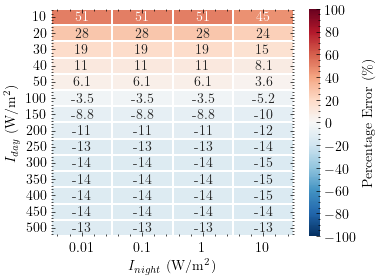

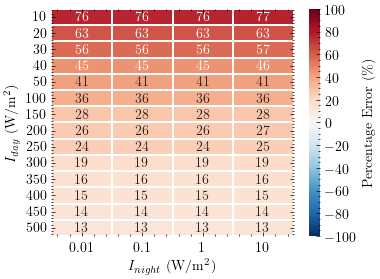

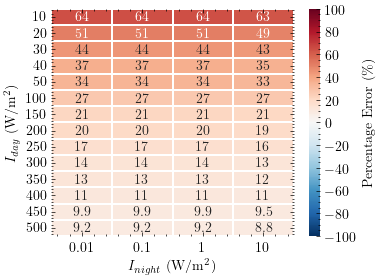

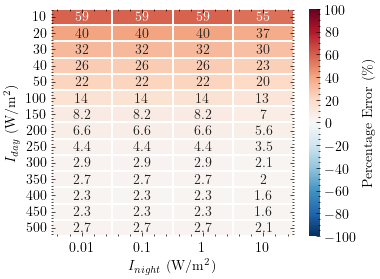

In [413]:
sensitivity_analysis_irradiance_threshold(df_part1,real_capacity_part1_cleaned,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1.pdf',base_load_correction_factor=base_load_correction_factor_from_part2)
sensitivity_analysis_irradiance_threshold(df_part1_1month_summer,real_capacity_part1_cleaned,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_1month_summer_PE.pdf',base_load_correction_factor=base_load_correction_factor_from_part2,metric='PE')
sensitivity_analysis_irradiance_threshold(df_part1_3months,real_capacity_part1_cleaned,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_3months_PE.pdf',base_load_correction_factor=base_load_correction_factor_from_part2,metric='PE')
sensitivity_analysis_irradiance_threshold(df_part1_6months,real_capacity_part1_cleaned,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_6months_PE.pdf',base_load_correction_factor=base_load_correction_factor_from_part2,metric='PE')

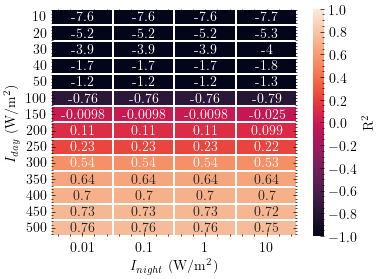

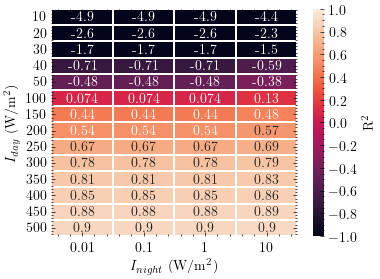

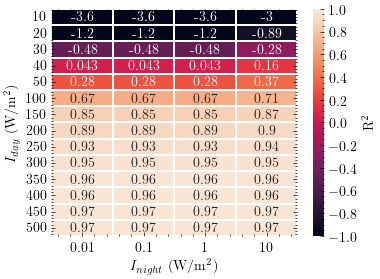

In [414]:
sensitivity_analysis_irradiance_threshold(df_part1_1month_summer,real_capacity_part1_cleaned,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_1month_summer_r2.pdf',base_load_correction_factor=base_load_correction_factor_from_part2,metric='R2')
sensitivity_analysis_irradiance_threshold(df_part1_3months,real_capacity_part1_cleaned,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_3months_r2.pdf',base_load_correction_factor=base_load_correction_factor_from_part2,metric='R2')
sensitivity_analysis_irradiance_threshold(df_part1_6months,real_capacity_part1_cleaned,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_6months_r2.pdf',base_load_correction_factor=base_load_correction_factor_from_part2,metric='R2')

# Estimation for part 2

In [415]:
# columns that ends with '_net'
net_cols = [col for col in df_part2.columns if col.endswith('_net')]
# remove total_net and households to remove from net_cols
net_cols_part2 = [col for col in net_cols if col != 'total_net' and col not in households_to_remove_with_suffix]
net_cols_without_total_net = [col for col in net_cols_part2 if col != 'total_net']
cap_est_based_load_part2 = capacity_estimation_base_load(df_part2,net_cols_without_total_net,base_load_correction_factor=base_load_correction_factor_from_part1)
capacity_based_load_part2 = cap_est_based_load_part2.estimate_capacity()
capacity_based_load_part2

3932W_net    1000.017630
4451M_net    5567.843758
5427W_net    1416.096083
5815T_net    2861.991587
7426U_net     738.223242
7679U_net    2387.658439
7710F_net     877.040866
8319Q_net    2808.088266
9248C_net     927.158542
9370J_net    2562.952176
9991J_net    6687.379462
dtype: float64

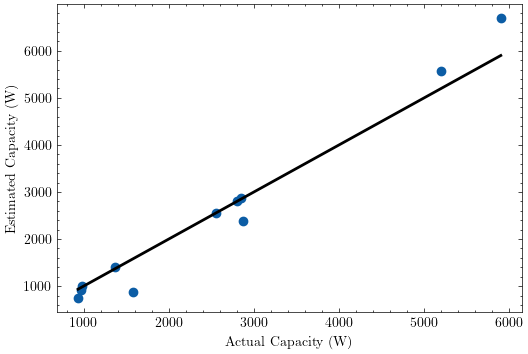

0.946302383659857

In [416]:
# plot the estimated capacity vs the actual capacity
# the second column of df_pv_capacity is the actual capacity
plot_actual_vs_predicted(df_pv_capacity_part2.iloc[:, 1], capacity_based_load_part2,fig_name='../figs/actual_vs_predicted_capacity_part2.pdf',xlabel='Actual Capacity (W)',ylabel='Estimated Capacity (W)',trendline=False)
calc_r2_score(df_pv_capacity_part2.iloc[:, 1], capacity_based_load_part2)

In [417]:
# sum up the capacity of all households both real and estimated
real_capacity_part2 = df_pv_capacity_part2['capacity'].sum()
estimated_capacity_part2 = capacity_based_load_part2.sum()
print(f'The real capacity is {real_capacity_part2} W, and the estimated capacity is {estimated_capacity_part2} W')
# print the error rate
capacity_error_rate_part2 = (real_capacity_part2 - estimated_capacity_part2) / real_capacity_part2 * 100
print(f'The error rate is {capacity_error_rate_part2}%')
error_factor_part2= real_capacity_part2/estimated_capacity_part2
print(f'The error factor is {error_factor_part2}')

The real capacity is 28001.352735605855 W, and the estimated capacity is 27834.45005268077 W
The error rate is 0.5960522139805549%
The error factor is 1.0059962629981622


In [418]:
# save the the error rate and error factor to npy files
np.save("../data/nl/capacity_error_rate_part2.npy", capacity_error_rate_part2)
np.save("../data/nl/capacity_error_factor_part2.npy", error_factor_part2)

## SA for part 2

In [419]:
real_capacity_part2= df_pv_capacity_part2['capacity'].to_numpy()

In [420]:
df_part2_1month_summer = df_part2[(df_part2['datetime'] >= '2018-06-01') & (df_part2['datetime'] <= '2018-06-30')]
df_part2_1month_winter = df_part2[(df_part2['datetime'] >= '2018-12-01') & (df_part2['datetime'] <= '2018-12-31')]
df_part2_3months = df_part2[(df_part2['datetime'] >= '2018-06-01') & (df_part2['datetime'] <= '2018-08-31')]
df_part2_6months = df_part2[(df_part2['datetime'] >= '2018-06-01') & (df_part2['datetime'] <= '2018-11-30')]

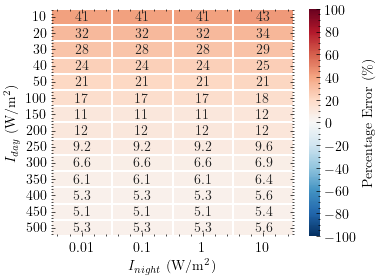

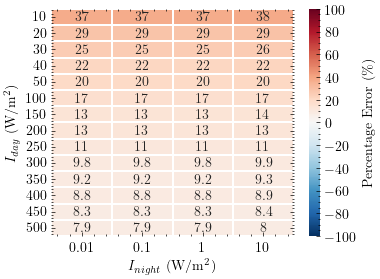

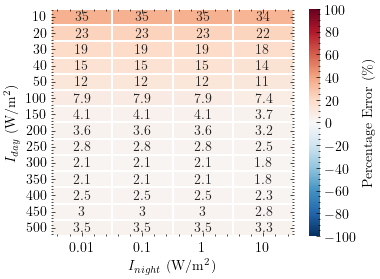

In [421]:
sensitivity_analysis_irradiance_threshold(df_part2_1month_summer,real_capacity_part2,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_1month_summer_PE.pdf',base_load_correction_factor=base_load_correction_factor_from_part1,metric='PE')
sensitivity_analysis_irradiance_threshold(df_part2_3months,real_capacity_part2,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_3months_PE.pdf',base_load_correction_factor=base_load_correction_factor_from_part1,metric='PE')
sensitivity_analysis_irradiance_threshold(df_part2_6months,real_capacity_part2,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_6months_PE.pdf',base_load_correction_factor=base_load_correction_factor_from_part1,metric='PE')

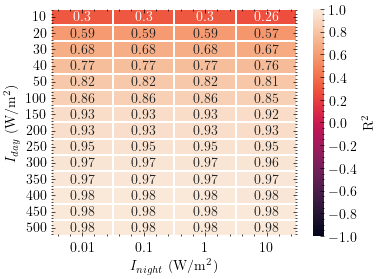

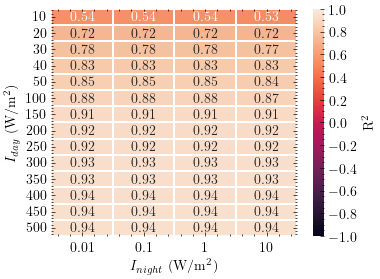

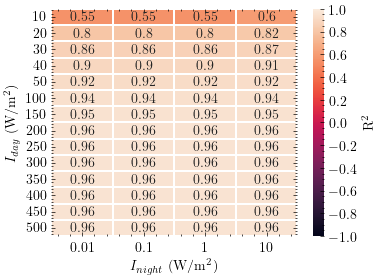

In [422]:
sensitivity_analysis_irradiance_threshold(df_part2_1month_summer,real_capacity_part2,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_1month_summer_r2.pdf',base_load_correction_factor=base_load_correction_factor_from_part1,metric='R2')
sensitivity_analysis_irradiance_threshold(df_part2_3months,real_capacity_part2,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_3months_r2.pdf',base_load_correction_factor=base_load_correction_factor_from_part1,metric='R2')
sensitivity_analysis_irradiance_threshold(df_part2_6months,real_capacity_part2,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_6months_r2.pdf',base_load_correction_factor=base_load_correction_factor_from_part1,metric='R2')